# User identification by browser history

Savchuk Andrei



### 1. Task and dataset.

The task is to identify users by their browsing history. The source database are lists of web bages with timestamp for every user in the sample.

There are samples with 10 and 150 users.



In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
#pip install tqdm
from tqdm import tqdm 
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import collections, functools, operator 
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
PATH_TO_DATA = 'capstone_user_identification' 

Посмотрим на данные по одному пользователю:

In [3]:
user31_data = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                       '10users/user0031.csv'))
user31_data.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


Для идентификации пользователя необходимо разбить исходный список посещенных сайтов на сессии из определенного колличества сайтов. По умолчанию объектом в этой задаче будет сессия из 10 сайтов. Целевой признак - пользователь (id). 

Для этого нужно подготовить выборку и привести ее к удобному формату. Для этого каждой посещенной пользователями странице нужно присвоить определенный номер и разбить выборку на сессии с указанием id пользователя.

Для удобства будем присваивать номера сайтам в порядке их убывания по популярности среди выборки. Напишем соответствующие функции для подсчета посещений и для присваивания номера: 

In [4]:
def count_sites_for_users(path_to_csv_files):
    #returns a list of dictionaties with count of sites for each file
    ID_acc = []
    for user_file in sorted(glob(os.path.join(path_to_csv_files,'*'))):
        ID_acc.append(collections.Counter())

        with open(user_file) as UF:
            empty_line = UF.readline()
            for line in UF.readlines():
                site = line.strip().split(',')[1]

                ID_acc[-1][site] += 1
    return ID_acc

In [5]:
def set_ids_to_sites(ID_count):
    #sort sites and assign IDs to them
    United_counts = functools.reduce(operator.add, 
                         map(collections.Counter, ID_count))
    
    sorted(United_counts)
    IDS = dict()
    num = 1
    for i in United_counts.most_common():
        IDS[i[0]] = (num, i[1])
        num += 1

    return IDS

Пример составленного словаря (сайт, номер, кол-во посещений) ниже

In [6]:
site_freqs_3users = count_sites_for_users(os.path.join(PATH_TO_DATA, '3users'))
set_ids_to_sites(site_freqs_3users)
                                                     

{'google.com': (1, 9),
 'oracle.com': (2, 8),
 'vk.com': (3, 3),
 'meduza.io': (4, 3),
 'mail.google.com': (5, 2),
 'football.kulichki.ru': (6, 2),
 'geo.mozilla.org': (7, 1),
 'accounts.google.com': (8, 1),
 'apis.google.com': (9, 1),
 'plus.google.com': (10, 1),
 'yandex.ru': (11, 1)}

Напишем функцию подготовки датасета. Параметры длинна сессии и кол-во сайтов между сессиями сделаем в виде аргументов.

In [7]:
def prepare_train_set_window(path_to_csv_files,
                                    session_length=10, window_size=10):
    #making site_to_id dictionary
    sites_counts = count_sites_for_users(path_to_csv_files)
    ID_dict = set_ids_to_sites(sites_counts)
    

    all_sessions = []
    y = []
    #reading file and transforming it to line of id's
    user_num = 1
    for user_file in tqdm(sorted(glob(os.path.join(path_to_csv_files,'*')))):
        user_site_line = list()
        with open(user_file) as UF:
            empty_line = UF.readline()
            for line in UF.readlines():
                site = line.strip().split(',')[1]
                user_site_line.append(ID_dict[site][0])
        
        #cutting line of id's into sessions
        division = []
        for i in range(0, len(user_site_line), window_size):
            division.append(i)
            division.append(i+session_length)
        sessions_raw = np.array_split(user_site_line, division)
        
        #cutting of empty sessions (array_split works that way)
        sessions = [sessions_raw[i] for i in range(1, len(sessions_raw), 2)]

        #filling incomplete sessions with 0-s and appending to common list 
        for i in range(len(sessions)):
            if len(sessions[i]) <  session_length:
                for j in range(len(sessions[i]),session_length,1):
                    sessions[i] = np.append(sessions[i], 0)
            all_sessions.append(sessions[i])
            y.append(user_num)
            
        user_num += 1

    #Sparced_train_data = csr_matrix(prepare_uranus(all_sessions))[:,1:]    

    return pd.DataFrame(all_sessions, columns=['site' + str(i) for i in range(1,session_length+1)]), y, ID_dict

In [8]:
train_data_10users, y_10users, site_freq_10users = prepare_train_set_window(os.path.join(PATH_TO_DATA, '10users'), 
                                                     session_length=10)

100%|██████████| 10/10 [00:00<00:00, 62.73it/s]


In [9]:
train_data_10users

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
0,192,574,133,3,133,133,3,133,203,133
1,415,193,674,254,133,31,393,3305,217,55
2,55,3,55,55,5,293,415,333,897,55
3,473,3306,473,55,55,55,55,937,199,123
4,342,55,5,3307,258,211,3308,2086,675,2086
...,...,...,...,...,...,...,...,...,...,...
14056,3,4,6,10,2,21,3,6,27,65
14057,10,21,65,27,30,3,4,9,4,30
14058,33,4,9,6,10,51,9,33,4,4
14059,4,4,4,43,51,4,3,3,9,4


Так как имеющиеся признаки являются по-факту категориальными, для обучения моделей следует их преобразовать в разряженную матрицу:

In [10]:
#напишем функцию подготовки данных к преобразованию в разряженный формат
def prepare_to_sparse(X):
    indices = np.array(X).flatten()
    data = np.ones(len(indices), dtype=int)
    indptr = np.array([len(X.iloc[0])*i for i in range(len(X)+1)])
    return data, indices, indptr

In [11]:
train_data_10users_sparse = csr_matrix(prepare_to_sparse(train_data_10users))[:,1:]   
train_data_10users_sparse

<14061x4913 sparse matrix of type '<class 'numpy.int64'>'
	with 140574 stored elements in Compressed Sparse Row format>

In [12]:
train_data_10users['user_id'] = y_10users

## 2.  Первичный анализ признаков

Посмотрим на распределение объектов выборки по пользователям:

In [13]:
train_data_10users['user_id'].value_counts()

7     2796
3     2204
8     1868
6     1712
9     1643
2     1022
4      802
1      760
5      720
10     534
Name: user_id, dtype: int64

Распределение по классам у выборки не равномерное.

Посмотрим распределение числа уникальных сайтов в каждой сессии:

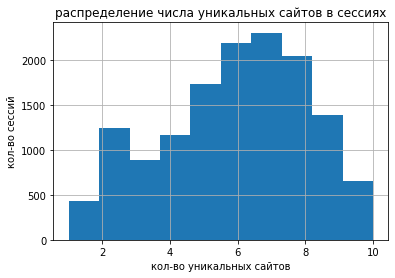

In [14]:
num_unique_sites = [np.unique(train_data_10users.values[i, :-1]).shape[0] 
                    for i in range(train_data_10users.shape[0])]
pd.Series(num_unique_sites).hist();
plt.title('распределение числа уникальных сайтов в сессиях')
plt.xlabel('кол-во уникальных сайтов')
plt.ylabel('кол-во сессий')
plt.show()

Проверим с помощью графика КК и критерия Шапиро-Уилка, что эта величина распределена нормально.

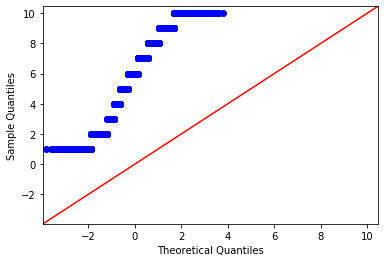

In [15]:
import statsmodels.api as sm 
import pylab as py 

sm.qqplot(np.array(num_unique_sites), line ='45') 
py.show() 

In [16]:
from scipy import stats
print('H0 : norm')
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(num_unique_sites))

H0 : norm
Shapiro-Wilk normality test, W-statistic: 0.954693, p-value: 0.000000


Гипотезу о нормальности распределения числа уникальных сайтов в сессии отвергаем

Проверим гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. То есть доля сессий в которых число уникальных сайтов в сессии < 10 велика: больше 95%. Применим биномиальноый критерий для доли. 

H0: - 95%, H1: > 95%

In [17]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')
pi_val = stats.binom_test(sum(has_two_similar), len(has_two_similar), 0.95, alternative = 'greater')

pi_val

0.02207653769072678

Мы отвергаем нулевую гипотезу, а следовательно можем утверждать что пользователи повторно заходят хотя-бы на один сайт за сессию.

Построим распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.

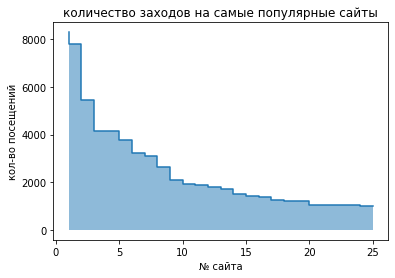

In [18]:
top_sites = []
for i in site_freq_10users.values():
    if i[1] > 1000:
        top_sites.append(i[1])
top_sites
plt.fill_between([i+1 for i in range(len(top_sites))], top_sites, step = 'pre', alpha=0.5)
plt.step([i+1 for i in range(len(top_sites))], top_sites)  
plt.title('количество заходов на самые популярные сайты')
plt.xlabel('№ сайта')
plt.ylabel('кол-во посещений')
plt.show()

Построим 95% доверительный интервал для средней частоты появления сайта в выборке (во всей, уже не только для тех сайтов, что были посещены как минимум 1000 раз) на основе bootstrap.

In [19]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [20]:
all_sites_freqs = np.array([i[1] for i in site_freq_10users.values()])
all_sites_freqs

array([8300, 7813, 5441, ...,    1,    1,    1])

In [21]:
mean_freqs = list(map(np.mean, get_bootstrap_samples(all_sites_freqs, 4913)))
print("95% confidence interval for mean freqs:",  stat_intervals(mean_freqs, 0.05))
interval = stat_intervals(mean_freqs, 0.05)

95% confidence interval for mean freqs: [22.51524527 35.76303684]


## 3. Создание дополнительных признаков и их анализ

На основе имеющихся данных выделим дополнительные признаки:

- session_timespan – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- #unique_sites – число уникальных сайтов в сессии
- start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)
- месяц.год
- частота посещения топ-30 популярных сайтов за сессию
- продолжительность посещения Facebook ('www.facebook.com') и youtube ('s.youtube.com', 'www.youtube.com') за сессию
- сайт с максимальной продолжительностью посещения

Соответственно модифицируем функцию обработки данных:

In [22]:
#объявим функцию нахождения ID по названию сайта
def find_id_for_site(ID_dict, site):
    for url, ids in list(ID_dict.items()):
        if url == site:
            return ids[0]
    return 0

def  feature_engineering(path_to_csv_files,
                                    session_length=10, window_size=10):
    #making site_to_id dictionary
    sites_counts = count_sites_for_users(path_to_csv_files)
    ID_dict = set_ids_to_sites(sites_counts)
    
    #пусть количество топ-сайтов будет вшито в функцию
    pop = 30
    
    top_popular = list(ID_dict.items())[:pop]
    top_sites = [i[0] for i in top_popular]
    top_indices = [i[1][0] for i in top_popular]
    #print(top_popular)
    facebook_id = find_id_for_site(ID_dict, 'www.facebook.com')
    youtube_id1 = find_id_for_site(ID_dict, 's.youtube.com')
    youtube_id2 = find_id_for_site(ID_dict, 'www.youtube.com')
    #print(facebook_id, youtube_id1, youtube_id2)
    
    all_sessions = []
    #y = []
    #reading file and transforming it to line of id's
    user_num = 1
    
    for user_file in tqdm(sorted(glob(os.path.join(path_to_csv_files,'*')))):
        user_site_line = list()
        with open(user_file) as UF:
            empty_line = UF.readline()
            for line in UF.readlines():
                site = line.strip().split(',')[1]
                time = pd.to_datetime(line.strip().split(',')[0])
                user_site_line.append([ID_dict[site][0], time])
        
        #cutting line of id's into sessions
        division = []
        for i in range(0, len(user_site_line), window_size):
            division.append(i)
            division.append(i+session_length)
        sessions_raw = np.array_split(user_site_line, division)
        
        #cutting of empty sessions (array_split works that way)
        sessions = [sessions_raw[i] for i in range(1, len(sessions_raw), 2)]
    
        #filling incomplete sessions with 0-s and appending to common list 
        for i in range(len(sessions)):
             #Находим значения для новых полей до заполнения нулями сессий
            start = min(sessions[i][:, 1])
            end = max(sessions[i][:, 1])
            session_timespan = int((end - start).total_seconds())   
            unique_sites = len(np.unique(sessions[i][:, 0]))
            start_hour = start.hour
            day_of_week = start.dayofweek
            
            #добавим признак по 30-ти популярным сайтам - время залипания
            facebook = 0
            youtube = 0
            top_times = np.zeros(pop)
            time_diffs = []
            for j in range(1, len(sessions[i])):
                #заполняем time_diff
                time_diffs.append(int((sessions[i][j][1] - sessions[i][j-1][1]).total_seconds()))
                if sessions[i][j-1][0] < pop:
                    #если сайт в топе - соответствующему полю добавляем время
                    top_times[sessions[i][j-1][0]-1] += 1
                    #проверяем facebook и youtube
                    if sessions[i][j-1][0] == facebook_id:
                        facebook += time_diffs[-1]
                    elif sessions[i][j-1][0] == youtube_id1 or sessions[i][j-1][0] == youtube_id2:
                        youtube += time_diffs[-1]
              
            # убираем метки времени
            sessions[i] = sessions[i][:, 0]
            
            #new features
            month_year = start.strftime('%Y.%m')
            #month = start.month
            #year = start.year
                      
            
            session = list(sessions[i])
            
            # заполняем нулями
            if len(sessions[i]) <  session_length:
                #list_like = list(sessions[i])
                for j in range(len(sessions[i]),session_length,1):
                    session.append(0)
                    time_diffs.append(0)
            
            #тут добавляем новые поля
            max_long = session[time_diffs.index(max(time_diffs))]  
            session = session + time_diffs \
                       + [session_timespan, unique_sites, start_hour, day_of_week, user_num, month_year] \
                           + list(top_times) + [facebook, youtube, max_long]
            
            all_sessions.append(session)
            
        user_num += 1
    
    feature_names = ['site' + str(i) for i in range(1,session_length+1)] + \
                ['time_diff' + str(j) for j in range(1,session_length)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target'] + ['month-year'] \
                + ['top_site_' + str(j) for j in range(1,pop+1)] + ['facebook', 'youtube', 'longest']

    return pd.DataFrame(all_sessions, columns = feature_names), list(zip(top_indices, top_sites))


In [23]:
new_features_10users, top_sites_10_users = feature_engineering(os.path.join(PATH_TO_DATA,'10users'), 
                  session_length=10)

100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


In [24]:
#проверяем правильность на пяти самых популярных сайтах в сессиях в которых есть фейсбук и ютуб
new_features_10users[new_features_10users.youtube > 0][new_features_10users.facebook > 0][['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8',
       'site9', 'site10', 'time_diff1', 'time_diff2', 'time_diff3',
       'time_diff4', 'time_diff5', 'time_diff6', 'time_diff7', 'time_diff8',
       'time_diff9', 'session_timespan', 'month-year', 'top_site_1', 'top_site_2',
       'top_site_3', 'top_site_4', 'top_site_5', 'facebook', 'youtube', 'longest']]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,session_timespan,month-year,top_site_1,top_site_2,top_site_3,top_site_4,top_site_5,facebook,youtube,longest
213,53,6,125,17,5,3,88,237,13,20,...,30,2013.12,0.0,0.0,1.0,0.0,1.0,14,11,5
1256,1,19,38,19,1,13,22,20,5,22,...,66,2014.02,2.0,0.0,0.0,0.0,1.0,14,15,22
1680,1,1,5,5,5,2,2192,2,2,237,...,34,2014.03,2.0,3.0,0.0,0.0,3.0,5,7,2192
2018,50,18,13,131,510,1015,510,5,5,492,...,3,2013.12,0.0,0.0,0.0,0.0,2.0,1,1,13
2142,50,5,13,306,5,34,34,34,5,5,...,148,2014.01,0.0,0.0,0.0,0.0,3.0,23,25,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9390,94,1,7,1,5,7,7,94,1,7,...,50,2014.04,3.0,0.0,0.0,0.0,1.0,1,22,7
9392,59,5,1,7,1,7,5,1,7,1,...,52,2014.04,3.0,0.0,0.0,0.0,2.0,24,15,5
9428,19,3,5,457,59,59,2452,5,13,19,...,14,2014.04,0.0,0.0,1.0,0.0,2.0,3,1,2452
10245,122,17,18,5,1,5,6,5,54,1,...,13,2013.11,1.0,0.0,0.0,0.0,3.0,10,1,5


Представим графически распределение дополнительных признаков. Для каждого пользователя зададим вымышленное имя и цвет для удобства отображения.

In [25]:
id_name_dict = {1: 'Mary-Kate', 2: 'Ashley', 3: 'Lindsey', 4: 'Naomi', 5: 'Avril',
               6: 'Bob', 7: 'Bill', 8: 'John', 9: 'Dick', 10: 'Ed'}
new_features_10users['name'] = new_features_10users['target'].map(id_name_dict)

color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

[]

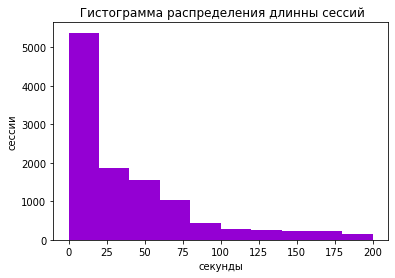

In [26]:
plt.hist(new_features_10users['session_timespan'], range = (0, 200), color = 'darkviolet')
plt.title(' Гистограмма распределения длинны сессий')
plt.xlabel('секунды')
plt.ylabel('сессии')
plt.plot()

**Построим гистограммы распределения числа уникальных сайтов в сессии (#unique_sites) для каждого из 10 пользователей по отдельности.**

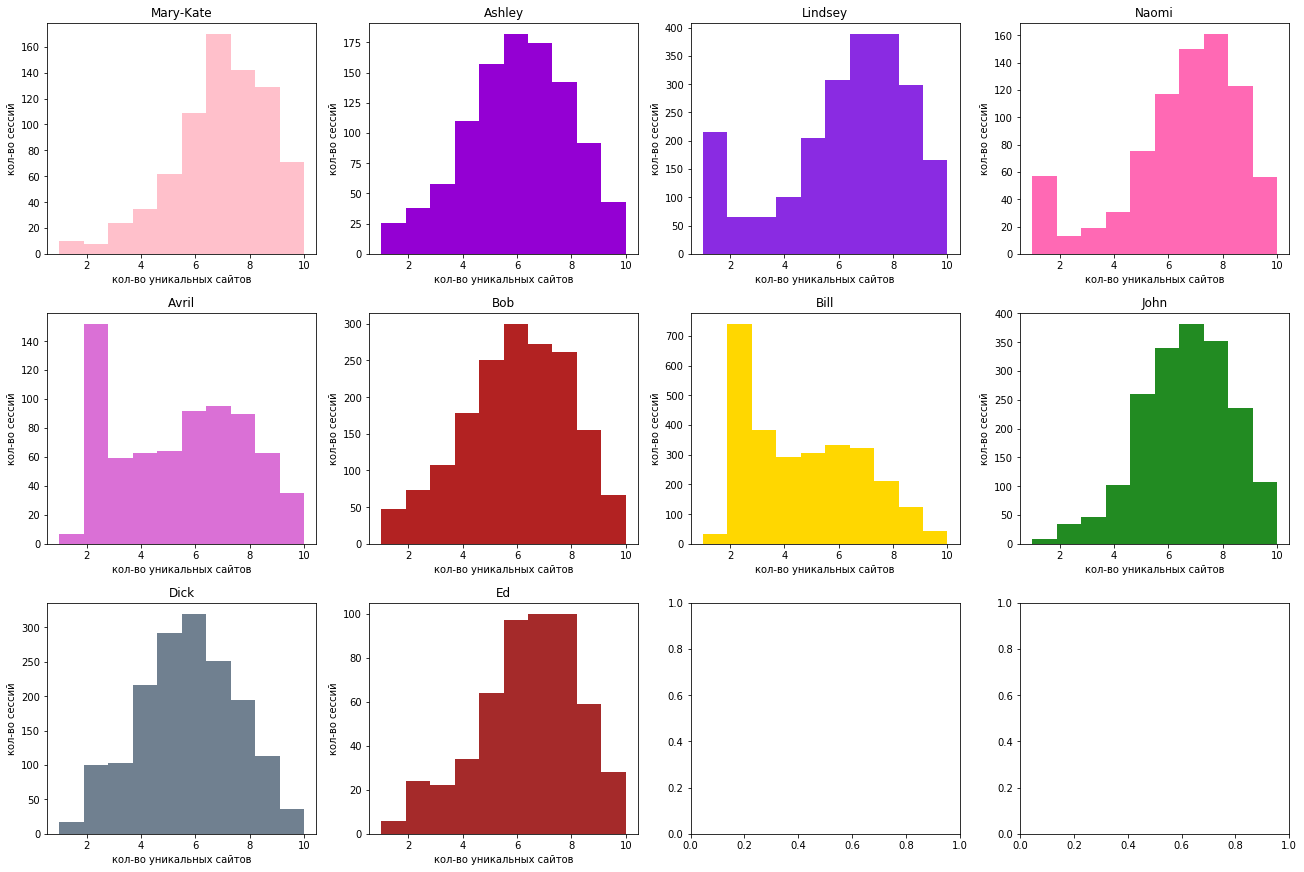

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), constrained_layout=True)

for i in range(0, 10):
    axes[i//4, i%4].hist(new_features_10users['#unique_sites'][new_features_10users.target == i+1], label = id_name_dict[i+1], color = color_dic[id_name_dict[i+1]])
    axes[i//4, i%4].set_xlabel('кол-во уникальных сайтов')
    axes[i//4, i%4].set_ylabel('кол-во сессий')
    axes[i//4, i%4].set_title(label = id_name_dict[i+1])

**Построим гистограмму распределения часа начала сессии общую и для каждого пользователя отдельно**

[]

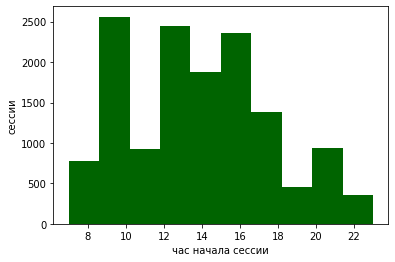

In [28]:
plt.hist(new_features_10users['start_hour'], color = 'darkgreen')
plt.xlabel('час начала сессии')
plt.ylabel('сессии')
plt.plot()

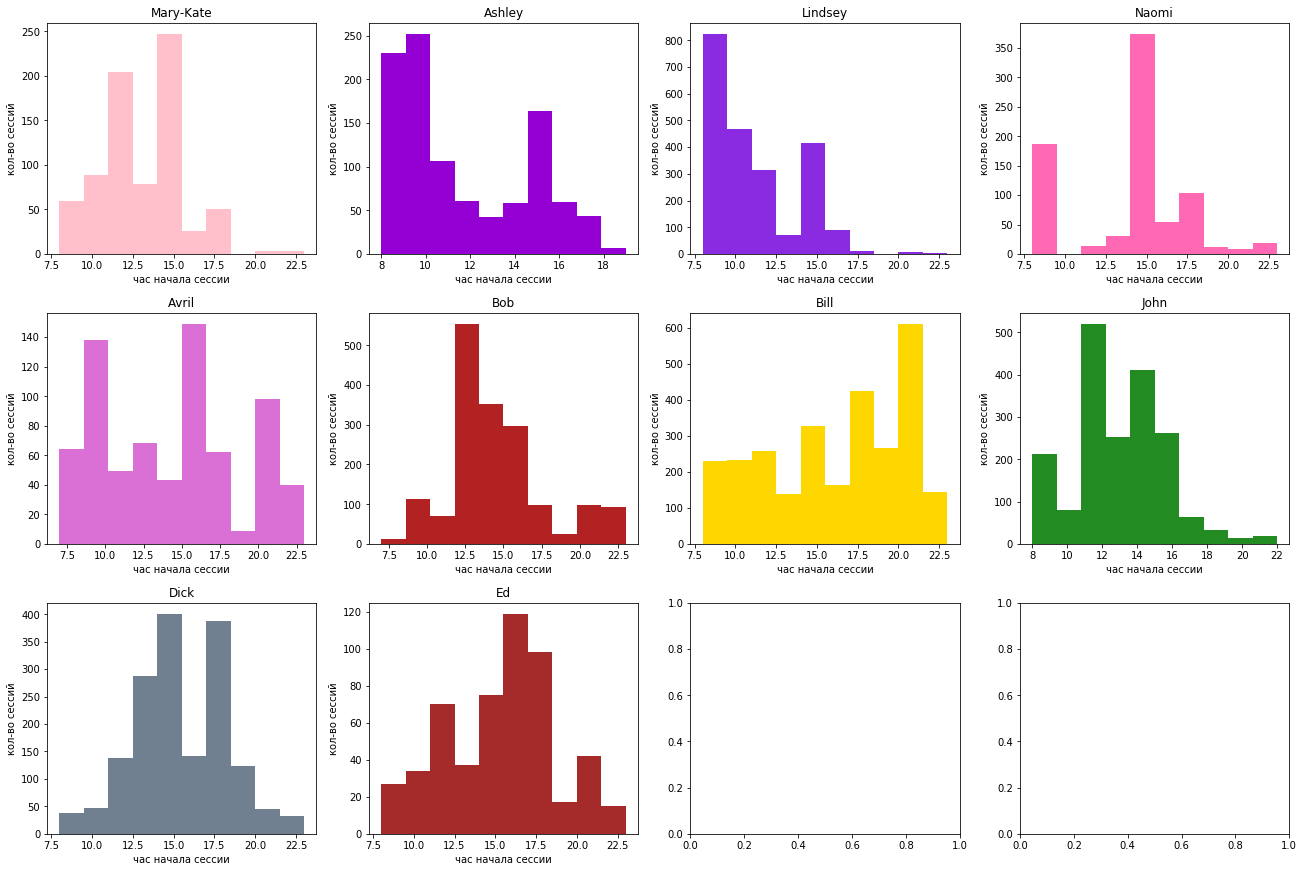

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), constrained_layout=True)

for i in range(0, 10):
    axes[i//4, i%4].hist(new_features_10users['start_hour'][new_features_10users.target == i+1], label = id_name_dict[i+1], color = color_dic[id_name_dict[i+1]])
    axes[i//4, i%4].set_xlabel('час начала сессии')
    axes[i//4, i%4].set_ylabel('кол-во сессий')
    axes[i//4, i%4].set_title(label = id_name_dict[i+1])

**Построим гистограмму распределения дня недели, в который началась сессия общую и для каждого пользователя отдельно**

[]

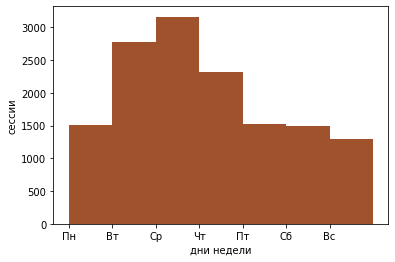

In [30]:
plt.hist(new_features_10users['day_of_week'], color = 'sienna', bins = np.arange(0, 8))
plt.xlabel('дни недели')
plt.ylabel('сессии')
plt.xticks(np.arange(7),  ('Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'))
plt.plot()

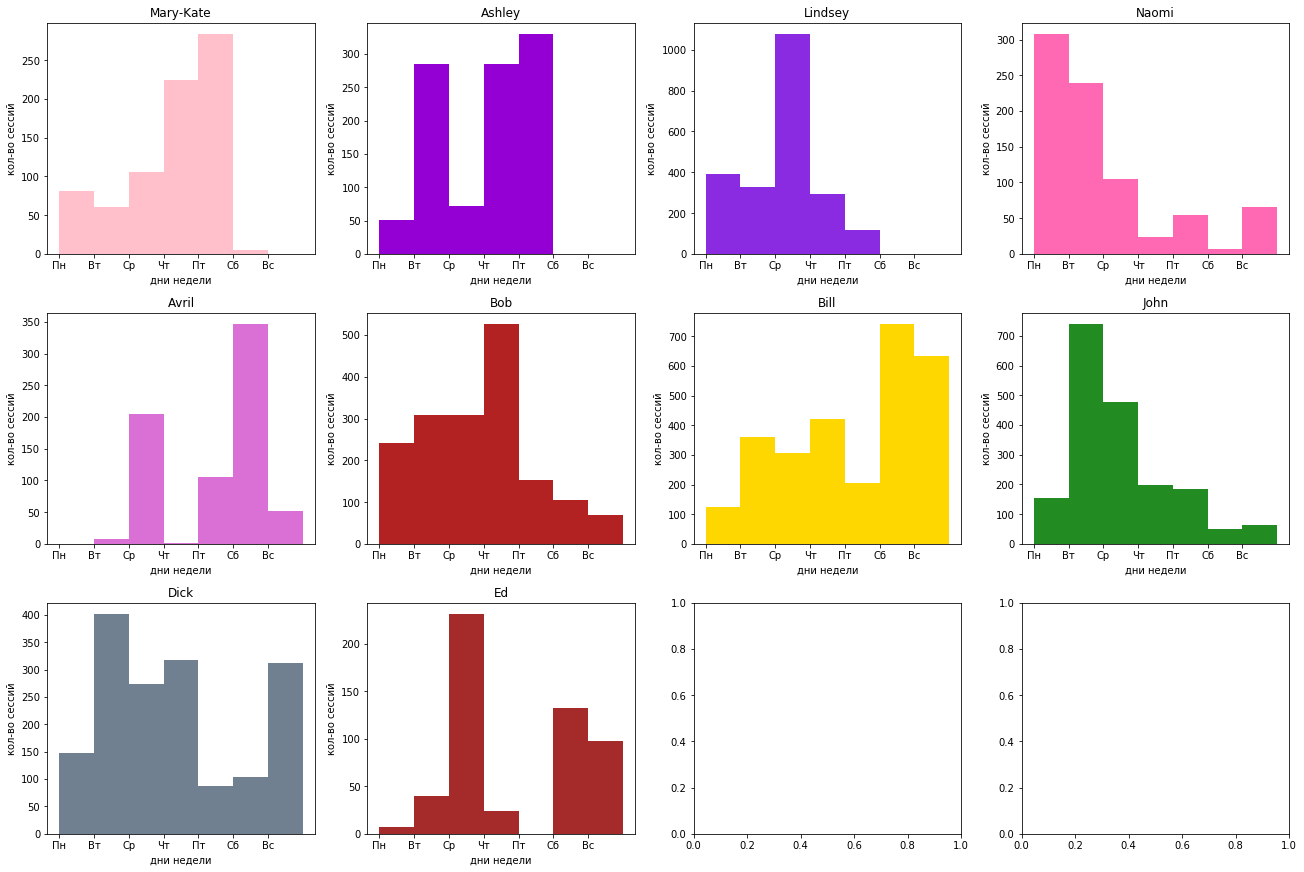

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), constrained_layout=True)

for i in range(0, 10):
    axes[i//4, i%4].hist(new_features_10users['day_of_week'][new_features_10users.target == i+1], bins = np.arange(0, 8), color = color_dic[id_name_dict[i+1]])
    axes[i//4, i%4].set_xlabel('дни недели')
    axes[i//4, i%4].set_ylabel('кол-во сессий')
    axes[i//4, i%4].set_xticks(np.arange(7))
    axes[i//4, i%4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    axes[i//4, i%4].set_title(label = id_name_dict[i+1])

**Сделаем предварительные выводы по рассмотренным признакам для каждого из пользователей:**

1: 'Mary-Kate', по выходным и вечерам практически не пользуется браузером, судя по всему сидит в интернете на работе. Количество уникальных сайтов больше чем у других пользователей.

2: 'Ashley', пользуется браузером только в рабочее время, возможно данные учитываются только с рабочей машины

3: 'Lindsey', аналогично предыдущему пользователю, только в среду всплеск активности. Достаточно часто заходит на один сайт за всю сессию

4: 'Naomi', активней пользуется в начале недели, утром и в обед.

5: 'Avril', практически не пользуется интернетом по понедельникам и четвергам. Обычно за сессию посещает 2 сайта

6: 'Bob', активно пользуется браузером, в основном в середине недели

7: 'Bill', в основном пользуется по выходным, в определенные часы меньше сессий чем в другие

8: 'John', в основном в рабочее время

9: 'Dick', пользуется часто и в разное время

10: 'Ed' пик активности в среду и по выходным. В пятницу нет совсем

Можно сделать предварительный вывод, что по рассмотренным выше признакам можно примерно определить пользователя. Что значит их следует использовать в модели классификации.

**Посмотрим на распределение посещенний 10-ти самых популярных сайтов:**

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.,
        9000.]),
 <a list of 10 Text xticklabel objects>)

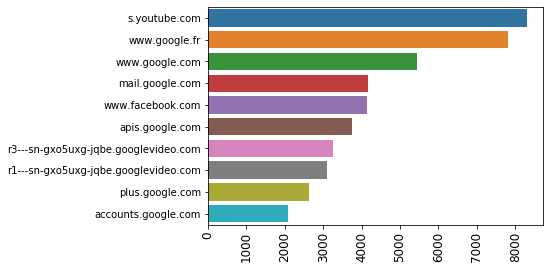

In [32]:
import seaborn as sns

top10_popular = list(site_freq_10users.items())[:10]
top10_freqs = [i[1][1] for i in top10_popular]
top10_sites = [i[0] for i in top10_popular]
ax = sns.barplot(top10_freqs, top10_sites)
plt.xticks(rotation='vertical', fontsize=12)


**посмотрим на распределение сессий по месяцам и годам**

[]

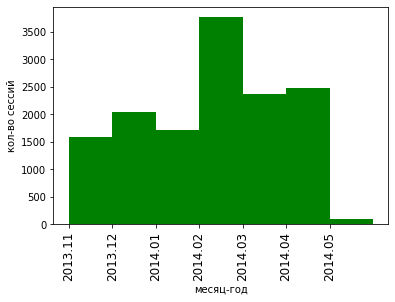

In [33]:
months_count = len(np.unique(new_features_10users['month-year'])) 
plt.hist(new_features_10users['month-year'], color = 'green', bins = np.arange(0, months_count+1))
plt.xlabel('месяц-год')
plt.ylabel('кол-во сессий')
plt.xticks(np.arange(months_count), rotation='vertical', fontsize=12)
plt.plot()

**Посмотрим на активность разных пользователей по месяцам**

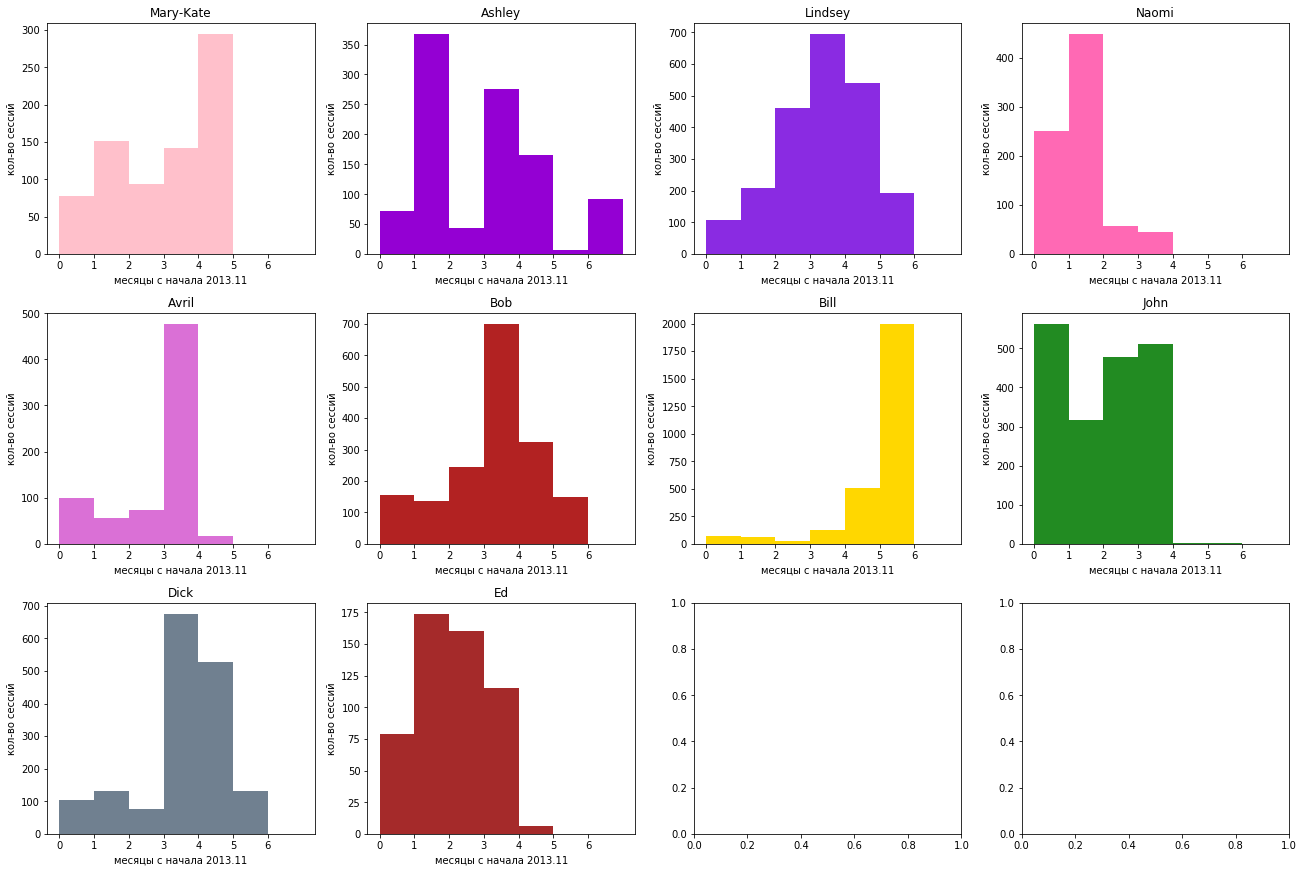

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), constrained_layout=True)
months_count = len(np.unique(new_features_10users['month-year'])) 
for i in range(0, 10):
    axes[i//4, i%4].hist(new_features_10users['month-year'][new_features_10users.target == i+1], color = color_dic[id_name_dict[i+1]], bins = np.arange(0, months_count+1))
    axes[i//4, i%4].set_xlabel('месяцы с начала 2013.11')
    axes[i//4, i%4].set_ylabel('кол-во сессий')
    axes[i//4, i%4].set_xticks(np.arange(months_count))
    axes[i//4, i%4].set_xticklabels(np.arange(months_count))
    axes[i//4, i%4].set_title(label = id_name_dict[i+1])

Как мы видим, по некоторым пользователям нет данных за последние 2-3 месяца. Также гистограммы довольно-таки сильно отличаются друг от друга.

**Посмотрим на посещаемость youtube разнимы пользователями.** 

Для масштабирования уберем с выборки сессии без посещения youtube.

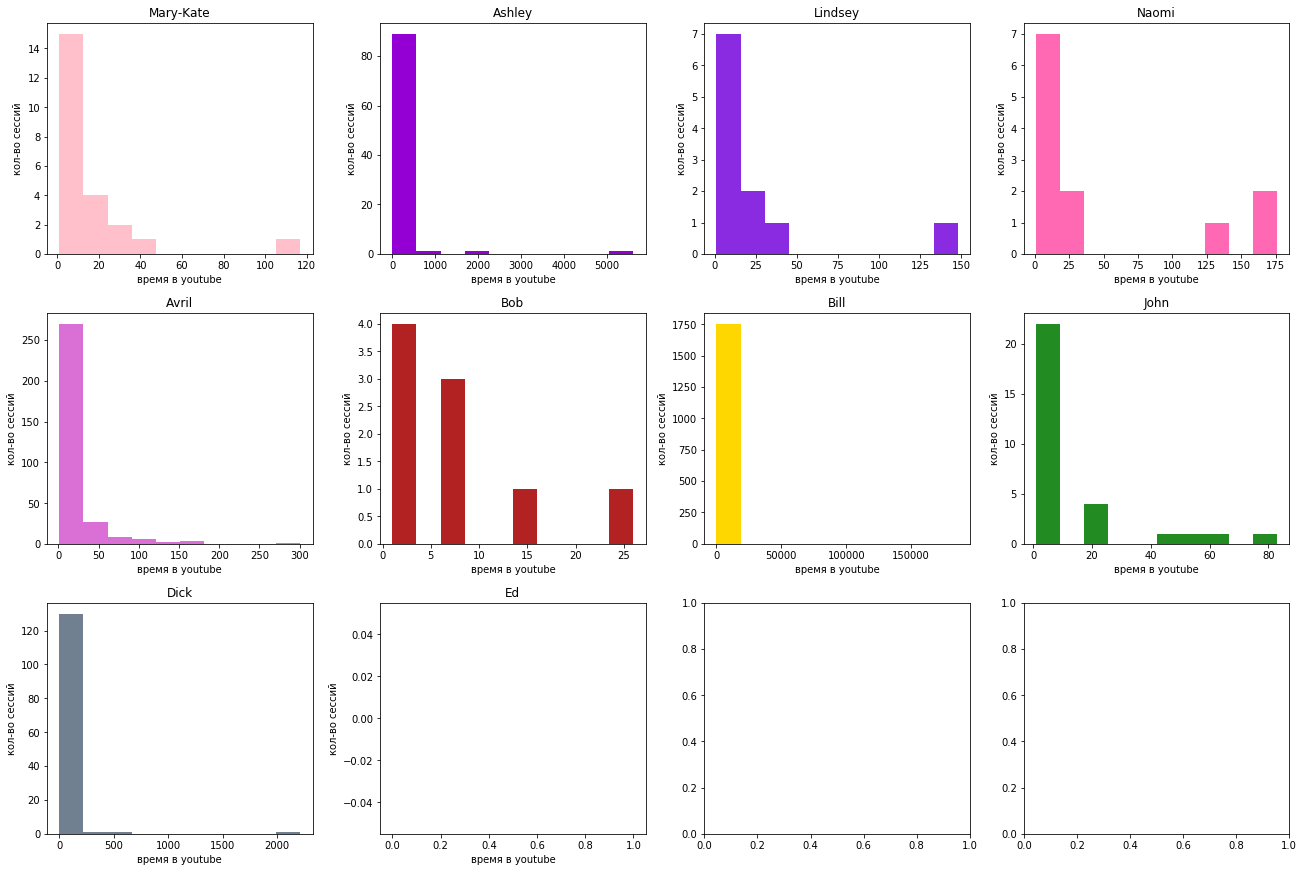

In [35]:
#
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), constrained_layout=True)

for i in range(0, 10):
    axes[i//4, i%4].hist(new_features_10users['youtube'][new_features_10users.youtube > 0][new_features_10users.target == i+1], color = color_dic[id_name_dict[i+1]])
    axes[i//4, i%4].set_xlabel('время в youtube')
    axes[i//4, i%4].set_ylabel('кол-во сессий')
    axes[i//4, i%4].set_title(label = id_name_dict[i+1])

Можно заметить, что пользователи в разной степени пользуются youtube. Только один пользователь (Ed) им не пользуется совсем.

**Посмотрим на распределение сайтов с наибольшей продолжительностью посещения**

[]

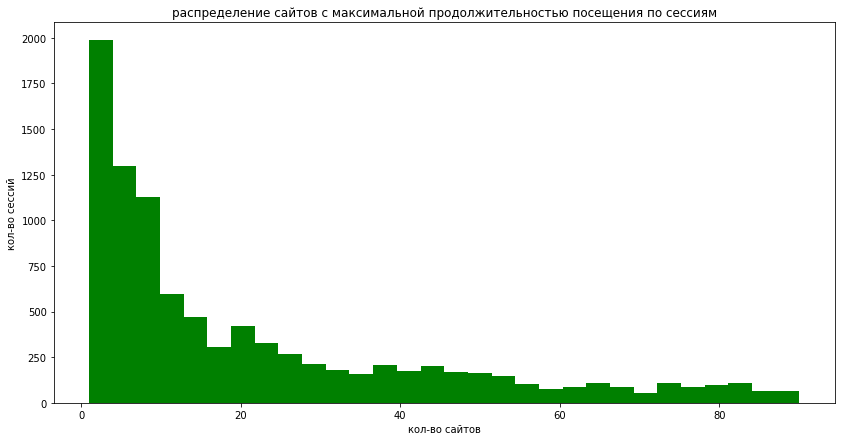

In [36]:
plt.figure(figsize=(14,7))
plt.hist(new_features_10users['longest'], color = 'green', range=(1, 90), bins = 30)
plt.xlabel('кол-во сайтов')
plt.ylabel('кол-во сессий')
plt.title('распределение сайтов с максимальной продолжительностью посещения по сессиям')
plt.plot()

Сайты пронумерованы в порядке убывания по популярности, поэтому видно что, за некоторыми исключениями, на популярных сайтах проводят больше времени. Посмотрим распределение для пользователей.

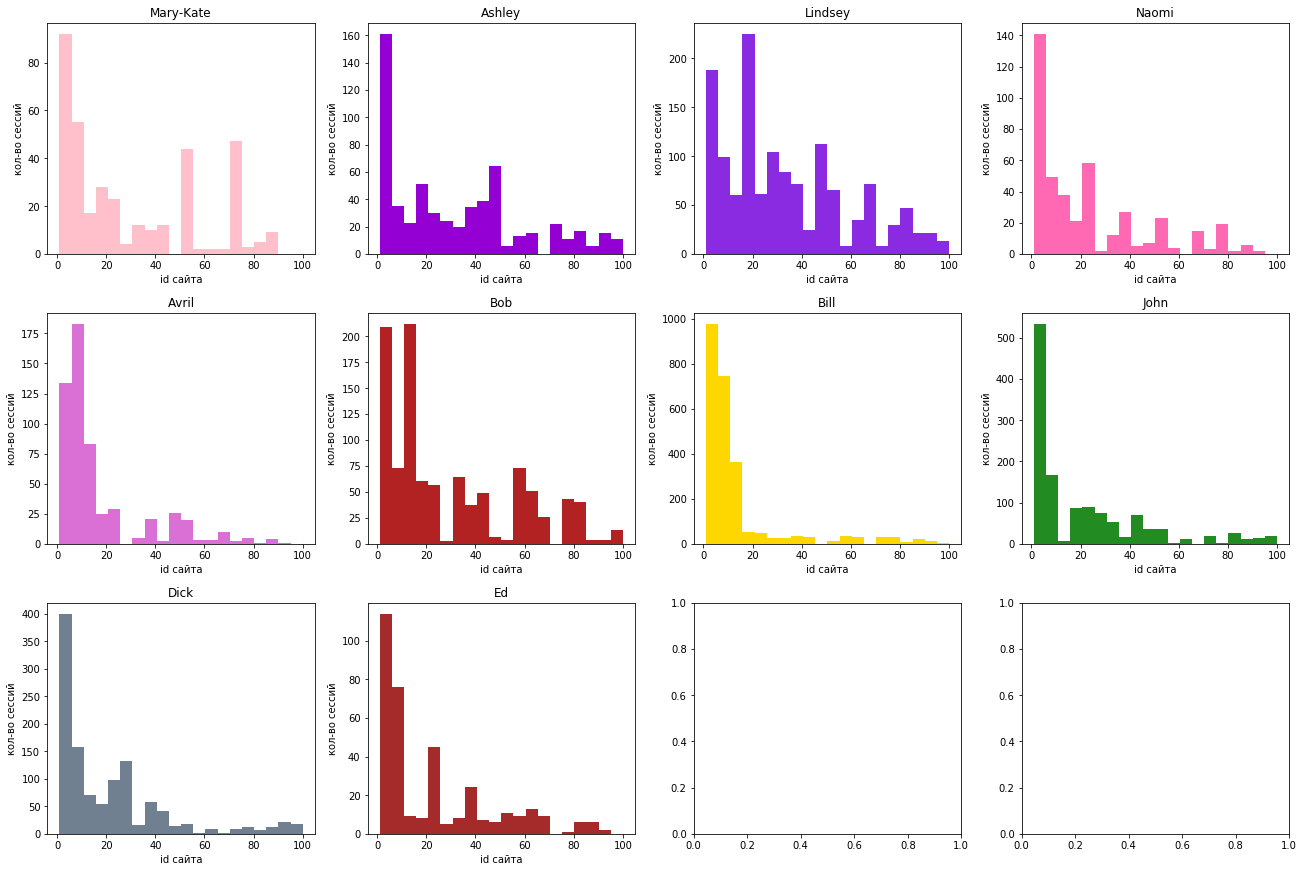

In [37]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), constrained_layout=True)

for i in range(0, 10):
    axes[i//4, i%4].hist(new_features_10users['longest'][new_features_10users.target == i+1], bins = 20, color = color_dic[id_name_dict[i+1]], range = (1, 100))
    axes[i//4, i%4].set_xlabel('id сайта')
    axes[i//4, i%4].set_ylabel('кол-во сессий')
    axes[i//4, i%4].set_title(label = id_name_dict[i+1])

Визуально этот параметр не дает какой-то дополнительной информации. Продолжительность нахождения на сайте определенно коррелирует с посещаемостью.

**Попробуем посмотреть на посещаемость 30-ти самых популярных сайтов разными пользователями**

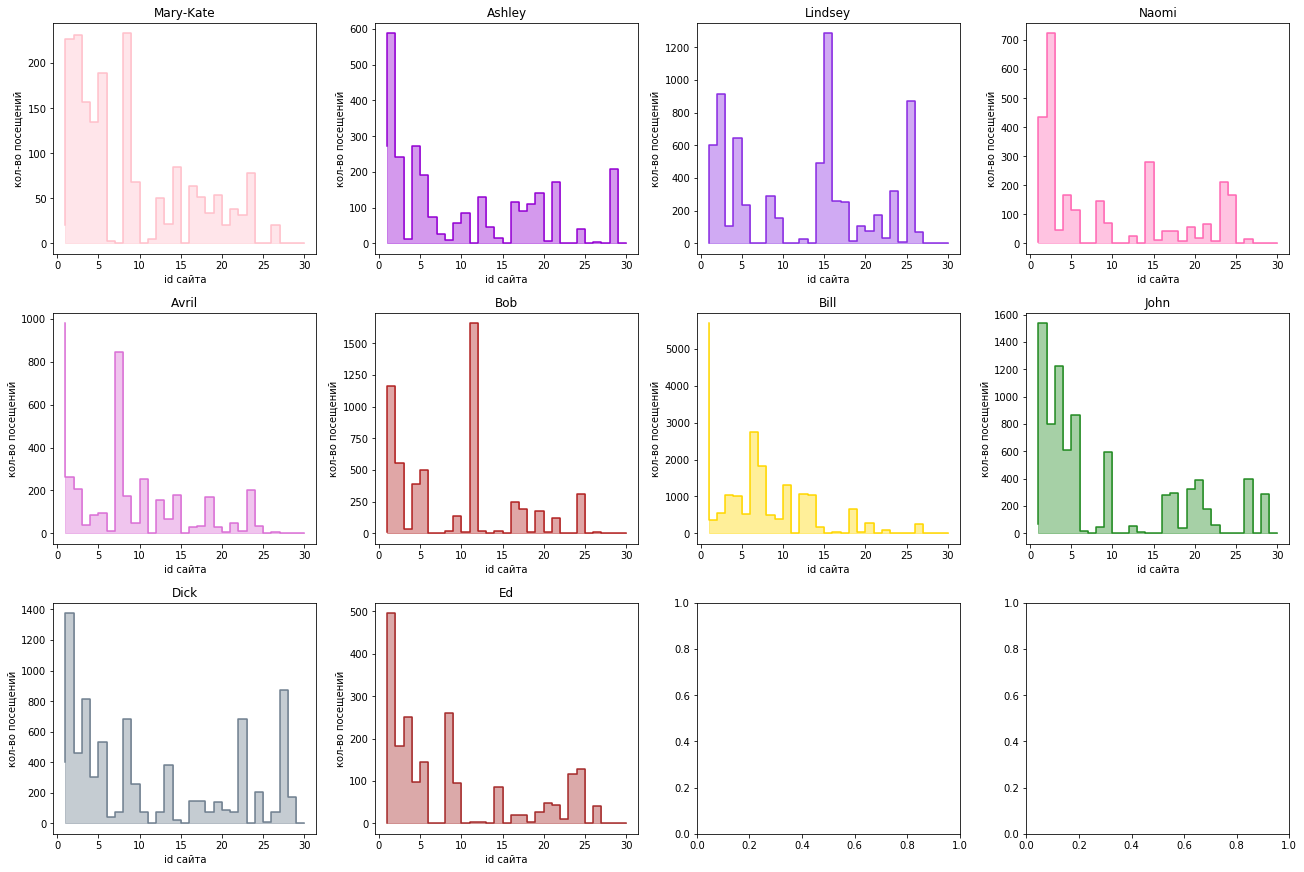

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), constrained_layout=True)

for i in range(0, 10):
    tops = np.zeros(31)
    for j in range(1,31):
        tops[j] = sum(new_features_10users['top_site_' + str(j)][new_features_10users.target == i+1])
    
    axes[i//4, i%4].fill_between([sit for sit in range(1, 31)], tops[1:], step = 'pre', alpha = 0.4, color = color_dic[id_name_dict[i+1]])
    axes[i//4, i%4].plot([sit for sit in range(1, 31)], tops[1:], color = color_dic[id_name_dict[i+1]], drawstyle = 'steps')
    axes[i//4, i%4].set_xlabel('id сайта')
    axes[i//4, i%4].set_ylabel('кол-во посещений')
    axes[i//4, i%4].set_title(label = id_name_dict[i+1])

Признаки кажутся информативным. Можно даже исключить 5 первых сайтов, по которым высокие значения практически у всех пользователей.

## 4. Сравнение моделей, подбор параметров, построение кривых валидации и обучения

На этом этапе выполним подбор параметров (длины сессии и ширины окна) и сравним на кросс-валидации несколько алгоритмов.
Для выбранного алгоритма построим кривые валидации и кривые обучения.


In [39]:
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [40]:
train_data_10users_sparse.shape

(14061, 4913)

Разобьем выборку на 2 части (70%/30%). На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data_10users_sparse, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

Зададим заранее тип кросс-валидации: 3-кратная, стратифицированная с перемешиванием.

In [42]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

Вспомогательная функция для отрисовки кривых валидации

In [43]:
def plot_validation_curves(param_values, grid_cv_results_):
    #train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    #train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    #plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
    #                 facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**Для начала сравним разные модели на train выборке с помощью кросс-валидации. В качестве метрики используем долю правильных ответов (accuracy score)**

- Обучим KNeighborsClassifier (метод ближайших соседей) с 30-тью соседями (остальные параметры по умолчанию)

In [44]:
#Метод ближайших соседей
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=30, n_jobs = 1)
CVS_train_knn = cross_val_score(knn, X_train, list(y_train), cv=skf)
print('Метод ближайших соседей \nСреднее качество на кросс-валидации',round(np.mean(CVS_train_knn),3))


Метод ближайших соседей 
Среднее качество на кросс-валидации 0.629


- Обучим случайный лес (RandomForestClassifier) из 100 деревьев.

In [45]:
#Случайный лес
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)
CVS_train_forest = cross_val_score(forest, X_train, list(y_train))
print('Случайный лес\nСреднее качество на кросс-валидации', round(np.mean(CVS_train_forest),3))

Случайный лес
Среднее качество на кросс-валидации 0.723


- Обучим логистическую регрессию (LogisticRegression) с параметром C (с=1) по умолчанию.

In [46]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
logit = LogisticRegression()
CVS_train_logit = cross_val_score(logit, X_train, list(y_train))
print('Логистическая регрессия c=1\nСреднее качество на кросс-валидации', round(np.mean(CVS_train_logit),3))

Логистическая регрессия c=1
Среднее качество на кросс-валидации 0.768


- Обучим линейный SVM (Метод опорных векторов) (LinearSVC) с параметром C=1

In [47]:
from sklearn.svm import LinearSVC
svm = LinearSVC(C=1)
CVS_train_svm = cross_val_score(svm, X_train, list(y_train), cv=skf)
print('Метод опорных векторов  с=1\nСреднее качество на кросс-валидации', round(np.mean(CVS_train_svm),3))

Метод опорных векторов  с=1
Среднее качество на кросс-валидации 0.751


- обучим модель градиентного бустинга на деревьях (XGBoost Classifier)

In [48]:
#XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier()
CVS_train_xgb = cross_val_score(xgb, X_train, list(y_train), cv=skf)
print('Градиентный бустинг на деревьях\nСреднее качество на кросс-валидации', round(np.mean(CVS_train_xgb),3))

Градиентный бустинг на деревьях
Среднее качество на кросс-валидации 0.713


- обучим модель SGDClassifier (стохастический градиентный спуск)

In [49]:
#SGDClassifier
from sklearn.linear_model import SGDClassifier
sgd_logit = SGDClassifier(loss = 'log')
CVS_train_sgd = cross_val_score(sgd_logit, X_train, list(y_train), cv=skf)
print('Стохастический градиентный спуск с\nСреднее качество на кросс-валидации', round(np.mean(CVS_train_sgd),3))

Стохастический градиентный спуск с
Среднее качество на кросс-валидации 0.755


**Выполним подбор параметров для самых удачных моделей (LogisticRegression, LinearSVC, SGDClassifier)**

- LogisticRegression, подбор параметров

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров C:
(1.0, 0.7606189739891912)
(1.1818181818181819, 0.7609237900897754)
(1.3636363636363638, 0.7609238210638735)
(1.5454545454545454, 0.7611269801740992)
(1.7272727272727273, 0.7612286371644575)
(1.9090909090909092, 0.761228699112654)
(2.090909090909091, 0.7602126557687399)
(2.2727272727272725, 0.7596029616193753)
(2.4545454545454546, 0.7598061826777975)
(2.6363636363636367, 0.7591965195025313)
(2.8181818181818183, 0.7593997405609533)
(3.0, 0.7597045566615374)


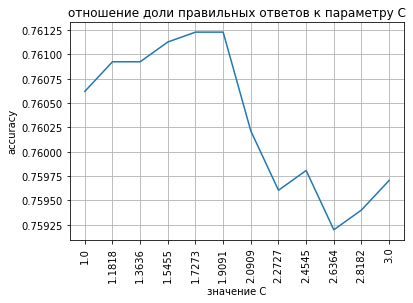

Лучшее значение: 1.9090909090909092 0.761228699112654
CPU times: user 3min 58s, sys: 38.6 s, total: 4min 37s
Wall time: 40.1 s


In [50]:
%%time
logit_c_values1 = np.linspace(1, 3, 12)

logit_grid_searcher = LogisticRegressionCV(Cs=logit_c_values1,n_jobs=1,random_state=17, cv=skf,multi_class='multinomial')
logit_grid_searcher.fit(X_train, list(y_train))

logit_mean_cv_scores1 = [np.mean(logit_grid_searcher.scores_[1][:,i]) for i in range(len(logit_c_values1))]
print('Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров C:')
for i in zip(logit_c_values1, logit_mean_cv_scores1):
    print(i)

plt.plot(range(len(logit_c_values1)), logit_mean_cv_scores1)
plt.title('отношение доли правильных ответов к параметру C')
plt.xlabel('значение C')
plt.xticks(range(len(logit_c_values1)),[round(i, 4) for i in logit_c_values1], rotation='vertical')
plt.ylabel('accuracy')
plt.grid(True, axis='both')
plt.show()

print('Лучшее значение:',logit_c_values1[np.where(logit_mean_cv_scores1 == max(logit_mean_cv_scores1))][0], max(logit_mean_cv_scores1))

In [51]:
logit_best = (logit_c_values1[np.where(logit_mean_cv_scores1 == max(logit_mean_cv_scores1))][0], max(logit_mean_cv_scores1))

- LinearSVC, подбор параметров

In [52]:
%%time
c_amount = 30
svm_params1 = {'C': np.linspace(1e-3, 1, c_amount)}

svm_grid_searcher = GridSearchCV(estimator=svm,param_grid=svm_params1)
svm_grid_searcher.fit(X_train, list(y_train))

CPU times: user 3min, sys: 161 ms, total: 3min 1s
Wall time: 3min 1s


GridSearchCV(cv=None, error_score=nan,
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

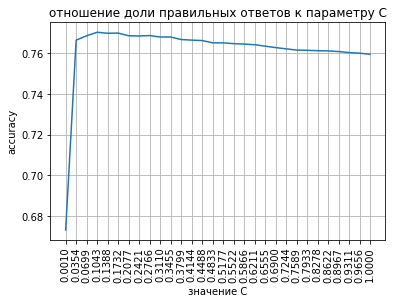

Лучшее значение: 0.10434482758620689 0.7701686093803548


In [53]:
svm_mean_scores1 = svm_grid_searcher.cv_results_['mean_test_score']
   
plt.plot(svm_params1['C'], svm_mean_scores1)
plt.title('отношение доли правильных ответов к параметру C')
plt.xlabel('значение C')
plt.xticks([round(i, 4) for i in svm_params1['C']], rotation='vertical')
plt.ylabel('accuracy')
plt.grid(True, axis='both')
plt.show()    
    
print('Лучшее значение:',svm_grid_searcher.best_estimator_.C,svm_grid_searcher.best_score_)

In [54]:
svm_best = (svm_grid_searcher.best_estimator_.C, svm_grid_searcher.best_score_)

- SGDClassifier, подбор параметров

In [55]:
alpha_n = 30
params = { 'alpha' : np.linspace(0.0005, 0.000001, alpha_n)}
#scoring='roc_auc'
sgd_classifier = SGDClassifier(loss='log')
sgd_grid_searcher = GridSearchCV(sgd_classifier, params,n_jobs=-1)
sgd_grid_searcher.fit(X_train, list(y_train))

GridSearchCV(cv=None, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1...
       2.93517241e-04, 2.76310345e-04, 2.59103448e-04, 2.41896552e-04,
       2.24689655e-04, 2.07482759e-04, 1.90275862e-04, 1.73068966e-04,
       1.55862069e-04, 1.38655172e-04, 1.21448276e-04, 1.04241379e-04,
       8.70344828e-05, 6.98275862e-05, 5.26206897e-05, 3.54137931e-05,
       1.82068966e-05, 1.00000000

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров C:


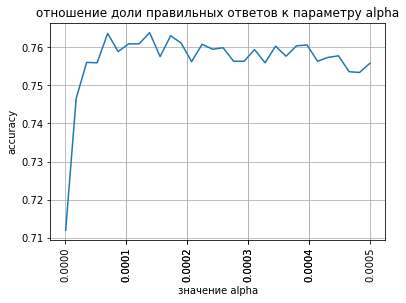

Лучшее значение: 0.0001386551724137931 0.7638694479885377


In [56]:
sgd_mean_scores1 = sgd_grid_searcher.cv_results_['mean_test_score']
print('Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров C:')
#for i in zip(params['alpha'], sgd_mean_scores1):
#    print(i)
    
plt.plot(params['alpha'], sgd_mean_scores1)
plt.title('отношение доли правильных ответов к параметру alpha')
plt.xlabel('значение alpha')
plt.xticks([round(params['alpha'][i], 4) for i in range(0, 30, 3)], rotation='vertical')
plt.ylabel('accuracy')
plt.grid(True, axis='both')
plt.show()    
    
print('Лучшее значение:',sgd_grid_searcher.best_estimator_.alpha,sgd_grid_searcher.best_score_)

 **Модели улучшили результаты, проверим теперь на тестовой выборке**

In [57]:
print('LogisticRegression accuracy: ', accuracy_score(logit_grid_searcher.predict(X_valid),list(y_valid)))
print('LinearSVC accuracy: ', accuracy_score(svm_grid_searcher.predict(X_valid),list(y_valid)))
print('SGDClassifier accuracy: ', accuracy_score(sgd_grid_searcher.predict(X_valid),list(y_valid)))

LogisticRegression accuracy:  0.7788575491822707
LinearSVC accuracy:  0.7807537331121118
SGDClassifier accuracy:  0.7705617444892154


Лучший результат дает линейный SVM (Метод опорных векторов)

**Выбор параметров функции подготовки данных – длины сессии и ширины окна**

Возьмем LinearSVC, показавший лучшее качество на кросс-валидации с параметром c=0.104, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров session_length и window_size).

In [58]:
import itertools

def model_assessment(estimator, X_sparse, y, cv, test_size=0.3):
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, list(y), 
                                                      test_size=test_size, 
                                                     stratify=list(y))
    
    model = cross_val_score(estimator, X_train, y_train, cv=cv)
    
    estimator.fit(X_train, y_train)
    
    AS = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return np.mean(model), AS

In [59]:
estimator = svm_grid_searcher.best_estimator_
scores=[]
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        #print(session_length, window_size)
        train_data_10users_sw, y_sw, site_freq_sw = prepare_train_set_window(os.path.join(PATH_TO_DATA, '10users'), 
                                                         session_length=session_length, window_size=window_size)
        
        X_sparced_sw = csr_matrix(prepare_to_sparse(train_data_10users_sw))[:,1:]   
        
        scores.append([session_length, window_size, model_assessment(svm_grid_searcher.best_estimator_, 
                 X_sparced_sw, y_sw, cv=skf, test_size=0.3)])
        
[print(i) for i in scores]
scores.sort(reverse=True, key=lambda z: z[2])
print('лучший результат: ', scores[0])



100%|██████████| 10/10 [00:00<00:00, 48.63it/s]


[15, 10, (0.8179236265465367, 0.8518606304811567)]
[10, 10, (0.7693548776770912, 0.7769613652524295)]
[15, 7, (0.8490044126070654, 0.8656047784967645)]
[10, 7, (0.7963015727795145, 0.8083623693379791)]
[7, 7, (0.7495734319973977, 0.7612410817985731)]
[15, 5, (0.8668328060738313, 0.8757705073494547)]
[10, 5, (0.8127224511556959, 0.8329777145566619)]
[7, 5, (0.7718728818232398, 0.7873399715504978)]
[5, 5, (0.7234531268780909, 0.7310336652441916)]
лучший результат:  [15, 5, (0.8668328060738313, 0.8757705073494547)]


**Лучший результат получается при длинне сессии = 15 и длинне "окна" = 5** (0.8793)

**Проверим модель на выборке в 150 пользователей:**

На этом этапе появилась проблема скорости обучения, на выборке на 150 пользователей обучение идет очень долго. Несмотря на небольшое понижение в качестве относительно LinearSVC, в дальнейшем будем использовать SGDClassifier, так как далее будем работать с выборкой еще большего объема.

In [60]:
%%time
data_150users, y_150_users, site_freq_150users = prepare_train_set_window(os.path.join(PATH_TO_DATA, '150users'), 
                                                         session_length=15, window_size=5)

data_150users_sparse = csr_matrix(prepare_to_sparse(data_150users))[:,1:]   

X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(data_150users_sparse, list(y_150_users), 
                                                      test_size=0.3, 
                                                     stratify=list(y_150_users))


sgd_grid_searcher.best_estimator_.fit(X_train_150, y_train_150)

AS_sgd_150 = accuracy_score(y_valid_150, sgd_grid_searcher.best_estimator_.predict(X_valid_150))

print('Оценка на тестовой части выборки из 150 пользователей:', AS_sgd_150)

100%|██████████| 150/150 [00:02<00:00, 74.31it/s]


Оценка на тестовой части выборки из 150 пользователей: 0.5185306857448776
CPU times: user 2min, sys: 6.67 s, total: 2min 7s
Wall time: 1min 19s


Ожидаемо, модель на 150-ти пользователях дает результат хуже. Определить 1 из 10 пользователей гораздо легче чем 1 из 150, несмотря на больший объем выборки. Тем не менее, почти каждый второй правильно определенный пользователь это хороший результат.

**Попробуем приметить модель для задачи определения конкретного пользователя (бинарная классификация)**

Подготовим соответствующие значения целевого признака (предварительно оценив отношение классов).
Для большей репрезентативности сравним успешность решения задачи для пользователем с разным колличеством сессий в выборке (минимальный, максимальный, медианный)

In [61]:
sessions_per_users = [[a, b] for a, b in zip(np.unique(y_150_users), 
    [sum([j == i for j in y_150_users]) for i in np.unique(y_150_users)])]

sessions_per_users.sort(key = lambda x: x[1])

min_user, max_user, mid_user = sessions_per_users[0][0], sessions_per_users[-1][0], sessions_per_users[len(sessions_per_users)//2][0]
y_min_user, y_max_user, y_mid_user = [i == min_user for i in y_150_users], [i == max_user for i in y_150_users], [i == mid_user for i in y_150_users]

Так как отношение объектов 1 к объектам 0 в для бинарной классификации очень маленькое, в дальнейшем в качестве метрики будем использовать **ROC_AUC**

In [62]:
from sklearn.metrics import roc_auc_score

sgd_per_user = SGDClassifier(alpha=0.00024189655172413796, loss='log')
X_train_150_user, X_valid_150_user, y_train_150_user, y_valid_150_user = train_test_split(data_150users_sparse, y_min_user, 
                                                      test_size=0.3, 
                                                     stratify=y_min_user)

sgd_per_user.fit(X_train_150_user, y_train_150_user)
RAS_sgd_user = roc_auc_score(y_valid_150_user, sgd_per_user.predict_proba(X_valid_150_user)[:,1])

print('Оценка на тестовой части выборки для пользователя с минимальным кол-вом сессий:', RAS_sgd_user)

X_train_150_user, X_valid_150_user, y_train_150_user, y_valid_150_user = train_test_split(data_150users_sparse, y_mid_user, 
                                                      test_size=0.3, 
                                                     stratify=y_mid_user)
sgd_per_user.fit(X_train_150_user, y_train_150_user)
RAS_sgd_user = roc_auc_score(y_valid_150_user, sgd_per_user.predict_proba(X_valid_150_user)[:,1])
print('Оценка на тестовой части выборки для пользователя со средним кол-вом сессий:', RAS_sgd_user)


X_train_150_user, X_valid_150_user, y_train_150_user, y_valid_150_user = train_test_split(data_150users_sparse, y_max_user, 
                                                      test_size=0.3, 
                                                     stratify=y_max_user)
sgd_per_user.fit(X_train_150_user, y_train_150_user)
RAS_sgd_user = roc_auc_score(y_valid_150_user, sgd_per_user.predict_proba(X_valid_150_user)[:,1])
print('Оценка на тестовой части выборки для пользователя с максимальным кол-вом сессий:', RAS_sgd_user)

Оценка на тестовой части выборки для пользователя с минимальным кол-вом сессий: 0.834225878255374
Оценка на тестовой части выборки для пользователя со средним кол-вом сессий: 0.916189608189471
Оценка на тестовой части выборки для пользователя с максимальным кол-вом сессий: 0.9578685795160337


**очевидно, что представленность пользователя в выборке влияет на качество модели**

В дальнейшем будем работать с пользователем со средним кол-вом сессий в выборке (пользователь 90)

### Построение кривых обучения

Построим кривые зависимости качества модели от объема выборки. В качестве метрик будем использовать Долю правильных ответов и ROC_AUC

In [63]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

In [64]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = sgd_grid_searcher.best_estimator_
n_train, val_train, val_test = learning_curve(estimator=estimator,
                                              X=data_150users_sparse,y=y_mid_user,
                                              train_sizes=train_sizes,cv=skf,shuffle=True,
                                             scoring='accuracy')

CPU times: user 38.8 s, sys: 3.22 s, total: 42.1 s
Wall time: 22.8 s


Text(0.5, 1.0, 'Кривая обучения. Метрика Доля правильных ответов (Accuracy)')

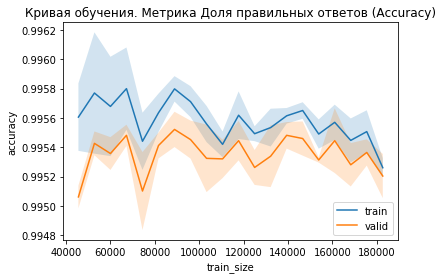

In [65]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')
plt.title('Кривая обучения. Метрика Доля правильных ответов (Accuracy)')

CPU times: user 42.2 s, sys: 3.49 s, total: 45.7 s
Wall time: 26.5 s


Text(0.5, 1.0, 'Кривая обучения. Метрика ROC AUC')

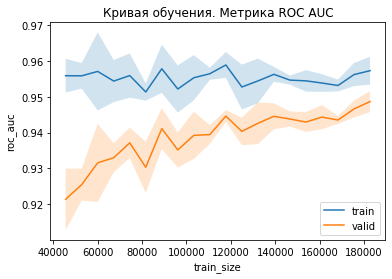

In [66]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = sgd_grid_searcher.best_estimator_
n_train, val_train, val_test = learning_curve(estimator=estimator,
                                              X=data_150users_sparse,y=y_mid_user,
                                              train_sizes=train_sizes,cv=skf,shuffle=True,
                                             scoring='roc_auc')

plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='roc_auc')
plt.title('Кривая обучения. Метрика ROC AUC')

## 5. Использование дополнительных признаков                                                   

Пока что модель использует только данные о последовательности посещенных сайтов.
Попробуем использовать ранее полученные значения признаков.

In [67]:
new_features_10users.columns

Index(['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8',
       'site9', 'site10', 'time_diff1', 'time_diff2', 'time_diff3',
       'time_diff4', 'time_diff5', 'time_diff6', 'time_diff7', 'time_diff8',
       'time_diff9', 'session_timespan', '#unique_sites', 'start_hour',
       'day_of_week', 'target', 'month-year', 'top_site_1', 'top_site_2',
       'top_site_3', 'top_site_4', 'top_site_5', 'top_site_6', 'top_site_7',
       'top_site_8', 'top_site_9', 'top_site_10', 'top_site_11', 'top_site_12',
       'top_site_13', 'top_site_14', 'top_site_15', 'top_site_16',
       'top_site_17', 'top_site_18', 'top_site_19', 'top_site_20',
       'top_site_21', 'top_site_22', 'top_site_23', 'top_site_24',
       'top_site_25', 'top_site_26', 'top_site_27', 'top_site_28',
       'top_site_29', 'top_site_30', 'facebook', 'youtube', 'longest', 'name'],
      dtype='object')

При этом надо учесть что часть из них является категориальными:

In [68]:
new_features_10users[['day_of_week', 'month-year']].head()

,day_of_week,month-year
0,4,2013.11
1,4,2013.11
2,4,2013.11
3,4,2013.11
4,4,2013.11


Получим значения исходной таблицы с доп параметрами для 150-ти пользователей с учетом параметров длинны сессии 15 и длинны окна 5:

In [69]:
Data_features_10u, top_sites_dict = feature_engineering(os.path.join(PATH_TO_DATA, '10users'),
                                    session_length=15, window_size=5)


100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


In [70]:
day_ow_dict = {0: 'Mo', 1: 'Tu', 2:'We', 3:'Th', 4:'Fr', 5:'St', 6:'Su'}
Data_features_10u['day_of_week'] = Data_features_10u['day_of_week'].map(day_ow_dict)

In [71]:
Data_features_10u.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,top_site_24,top_site_25,top_site_26,top_site_27,top_site_28,top_site_29,top_site_30,facebook,youtube,longest
0,192,574,133,3,133,133,3,133,203,133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,674
1,133,3,133,203,133,415,193,674,254,133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,674
2,415,193,674,254,133,31,393,3305,217,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,55
3,31,393,3305,217,55,55,3,55,55,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,55
4,55,3,55,55,5,293,415,333,897,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,55


In [72]:
#from sklearn.preprocessing import LabelEncoder
Data_features_10u = pd.get_dummies(Data_features_10u, prefix='dt_', columns=['day_of_week', 'month-year'], dtype='int')
Data_features_10u.columns

Index(['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8',
       'site9', 'site10', 'site11', 'site12', 'site13', 'site14', 'site15',
       'time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5',
       'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9', 'time_diff10',
       'time_diff11', 'time_diff12', 'time_diff13', 'time_diff14',
       'session_timespan', '#unique_sites', 'start_hour', 'target',
       'top_site_1', 'top_site_2', 'top_site_3', 'top_site_4', 'top_site_5',
       'top_site_6', 'top_site_7', 'top_site_8', 'top_site_9', 'top_site_10',
       'top_site_11', 'top_site_12', 'top_site_13', 'top_site_14',
       'top_site_15', 'top_site_16', 'top_site_17', 'top_site_18',
       'top_site_19', 'top_site_20', 'top_site_21', 'top_site_22',
       'top_site_23', 'top_site_24', 'top_site_25', 'top_site_26',
       'top_site_27', 'top_site_28', 'top_site_29', 'top_site_30', 'facebook',
       'youtube', 'longest', 'dt__Fr', 'dt__Mo', 'dt_

In [73]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

In [74]:
New_features_only_10users = Data_features_10u.drop(['site' + str(i) for i in range(1,15+1)],axis='columns')


In [75]:
Sites_only_10users = Data_features_10u[['site' + str(i) for i in range(1,15+1)]]

In [76]:
y_10users_15_5 = list(New_features_only_10users.target)
New_features_only_10users = New_features_only_10users.drop(['target'],axis='columns')

In [77]:
New_features_only_10users.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,time_diff10,...,dt__Th,dt__Tu,dt__We,dt__2013.11,dt__2013.12,dt__2014.01,dt__2014.02,dt__2014.03,dt__2014.04,dt__2014.05
0,10,0,0,1,20,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,0,1,0,0,1,0,163,105,0,...,0,0,0,1,0,0,0,0,0,0
2,1,0,163,105,0,1,3,3,8,1,...,0,0,0,1,0,0,0,0,0,0
3,1,3,3,8,1,0,14,1,242,0,...,0,0,0,1,0,0,0,0,0,0
4,0,14,1,242,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [78]:
#попробуем подобрать модель только на этих данных

X_train, X_valid, y_train, y_valid = train_test_split(New_features_only_10users, y_10users_15_5, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users_15_5)

#Обучим логистическую регрессию (LogisticRegression) с параметром C (с=1) по умолчанию.
#LogisticRegression

logit = LogisticRegression()
CVS_train_logit = cross_val_score(logit, X_train, list(y_train))
print('Логистическая регрессия c=1\nСреднее качество на кросс-валидации', round(np.mean(CVS_train_logit),3))

#Обучим линейный SVM (Метод опорных векторов) (LinearSVC) с параметром C=1


svm = LinearSVC(C=1)
CVS_train_svm = cross_val_score(svm, X_train, list(y_train), cv=skf)
print('Метод опорных векторов  с=1\nСреднее качество на кросс-валидации', round(np.mean(CVS_train_svm),3))

#обучим модель SGDClassifier (стохастический градиентный спуск)

sgd_logit = SGDClassifier(loss = 'log')
CVS_train_sgd = cross_val_score(sgd_logit, X_train, list(y_train), cv=skf)
print('Стохастический градиентный спуск с\nСреднее качество на кросс-валидации', round(np.mean(CVS_train_sgd),3))

#Случайный лес
forest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)
CVS_train_forest = cross_val_score(forest, X_train, list(y_train))
print('Случайный лес\nСреднее качество на кросс-валидации', round(np.mean(CVS_train_forest),3))


Логистическая регрессия c=1
Среднее качество на кросс-валидации 0.228
Метод опорных векторов  с=1
Среднее качество на кросс-валидации 0.479
Стохастический градиентный спуск с
Среднее качество на кросс-валидации 0.205
Случайный лес
Среднее качество на кросс-валидации 0.889


Как мы видим, на дополнительных признаках определенно лучший результат дает Случайный лес

Попробуем включить в данные результат работы предыдущей модели.

In [79]:
X_train, X_valid, y_train, y_valid = train_test_split(Data_features_10u.drop(['target'], axis='columns'), y_10users_15_5, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users_15_5)


In [80]:
X_train_fe = X_train.drop(['site' + str(i) for i in range(1,15+1)],axis='columns')
X_train_sites = X_train[['site' + str(i) for i in range(1,15+1)]]
X_valid_fe = X_valid.drop(['site' + str(i) for i in range(1,15+1)],axis='columns')
X_valid_sites = X_valid[['site' + str(i) for i in range(1,15+1)]]

X_train_sites_sparse = csr_matrix(prepare_to_sparse(X_train_sites))[:,1:]  
X_valid_sites_sparse = csr_matrix(prepare_to_sparse(X_valid_sites))[:,1:]  

In [81]:
sgd_grid_searcher.best_estimator_.fit(X_train_sites_sparse, y_train)
X_train_fe['sgd_proba'] = sgd_grid_searcher.best_estimator_.predict(X_train_sites_sparse)
X_valid_fe['sgd_proba'] = sgd_grid_searcher.best_estimator_.predict(X_valid_sites_sparse)

In [82]:
forest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)
CVS_train_forest = cross_val_score(forest, X_train_fe, y_train)
print('Случайный лес (с результатами SGD модели)\nСреднее качество на кросс-валидации', round(np.mean(CVS_train_forest),3))

Случайный лес (с результатами SGD модели)
Среднее качество на кросс-валидации 0.956


Модели улучшили результаты (до этого максимальный результат был - 0.8793, проверим теперь на тестовой выборке:

In [83]:
forest.fit(X_train_fe, y_train)
print('Random Forest accuracy: ', accuracy_score(forest.predict(X_valid_fe),y_valid))

Random Forest accuracy:  0.9467757230915126


**Итого лучший результат на 0.3 тестовой выборке из 10 пользователей - 0.94**

**Попробуем применить модель для одного пользователя из 150-ти**

In [84]:
%%time
Data_features_150u, top_sites_dict = feature_engineering(os.path.join(PATH_TO_DATA, '150users'),
                                    session_length=15, window_size=5)
Data_features_150u['day_of_week'] = Data_features_150u['day_of_week'].map(day_ow_dict)
Data_features_150u = pd.get_dummies(Data_features_150u, prefix='dt_', columns=['day_of_week', 'month-year'], dtype='int')
y_all_150users = Data_features_150u.target
y_user_90 = [i == mid_user for i in y_all_150users]


100%|██████████| 150/150 [03:45<00:00,  1.50s/it]


CPU times: user 3min 52s, sys: 1.54 s, total: 3min 53s
Wall time: 3min 53s


In [85]:
X_train, X_valid, y_train, y_valid = train_test_split(Data_features_150u.drop(['target'], axis='columns'), y_user_90, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_user_90)
X_train_fe = X_train.drop(['site' + str(i) for i in range(1,15+1)],axis='columns')
X_train_sites = X_train[['site' + str(i) for i in range(1,15+1)]]
X_valid_fe = X_valid.drop(['site' + str(i) for i in range(1,15+1)],axis='columns')
X_valid_sites = X_valid[['site' + str(i) for i in range(1,15+1)]]

X_train_sites_sparse = csr_matrix(prepare_to_sparse(X_train_sites))[:,1:]  
X_valid_sites_sparse = csr_matrix(prepare_to_sparse(X_valid_sites))[:,1:]  

In [86]:
sgd_grid_searcher.best_estimator_.fit(X_train_sites_sparse, y_train)
X_train_fe['sgd_proba'] = sgd_grid_searcher.best_estimator_.predict(X_train_sites_sparse)
X_valid_fe['sgd_proba'] = sgd_grid_searcher.best_estimator_.predict(X_valid_sites_sparse)

In [87]:
forest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)
CVS_train_forest = cross_val_score(forest, X_train_fe, y_train)
print('Случайный лес (с результатами SGD модели)\nСреднее качество на кросс-валидации', round(np.mean(CVS_train_forest),3))

Случайный лес (с результатами SGD модели)
Среднее качество на кросс-валидации 0.996


In [88]:
forest.fit(X_train_fe, y_train)
print('Random Forest accuracy: ', accuracy_score(forest.predict(X_valid_fe),y_valid))

Random Forest accuracy:  0.9964715043558671


In [89]:
RAS_sgd_user = roc_auc_score(y_valid, forest.predict_proba(X_valid_fe)[:,1])
print('ROC AUC Оценка на тестовой части выборки:', RAS_sgd_user)

ROC AUC Оценка на тестовой части выборки: 0.9930570743922943


Text(0.5, 1.0, 'ROC-кривая')

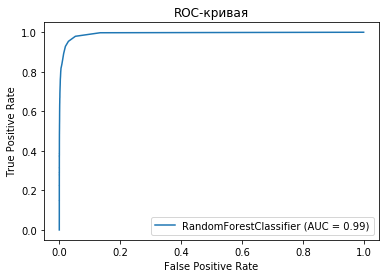

In [90]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(forest, X_valid_fe, y_valid)
plt.title('ROC-кривая')

Посмотрим на точность и полноту решения:

In [91]:
from sklearn.metrics import precision_score, recall_score
print('Точность (precision): ', precision_score(y_valid, forest.predict(X_valid_fe)))
print('Полнота (recall): ', recall_score(y_valid, forest.predict(X_valid_fe)))

Точность (precision):  0.9316239316239316
Полнота (recall):  0.27877237851662406


# 6. Выводы


В качестве учебного проекта решалась задача идентификации пользователя по посещенным им сайтам в интернете.

На практике решение этой задачи может позволить идентифицировать злоумышленника, получившего доступ к чужому профилю или рабочей машине. Можно отслеживать определенного пользвателя на разных устройствах. А также собирать информацию в маркетинговых целях.

По ходу построения модели были выполнены:
- анализ исходных данных
- предобработка данных 
- выделение и анализ дополнительных признаков
- сравнение разных моделей
- подбор параметров
- анализ качества модели, построение кривых обучения
- улучшение качества путем построения дополнительной модели на дополнительных признаках

На тестовой выборке из 150-ти пользователей итоговая модель дала следующие значения метрик:

- Доля правильных ответов определения всех 10-ти пользователей:  0.9400

- Идентификация конкретного пользователя из 150-ти (Бинарная классификация):
   - Доля правильных ответов: 0.9962
   - Точность: 0.9130
   - Полнота: 0.2148
   - ROC AUC score: 0.9861

Это значит примерно каждая пятая сессия конкретного пользователя и примерно 9 из 10 предсказанных модельню сессий пользователя определена моделью правильно. 

Для лучшей репрезентативности модели был выбран пользователь с медианным количеством объектов в выборке.


Хотя основываясь только на этой модели делать точную идентификацию может быть не очень надежно (4 из 5-ти сессий будет считаться злоумышленником), ее вполне можно использовать в комплексе с другими средствами.